## Importing packages

In [1]:
from skfem import *
from skfem.models.poisson import unit_load
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import dd, ddot
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Morley

Problem:
$$ \Delta^2 u = 1 \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
Form:
$$ \int_\Omega \boldsymbol{K}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V $$

### Standard solution

Wall time: 112 ms


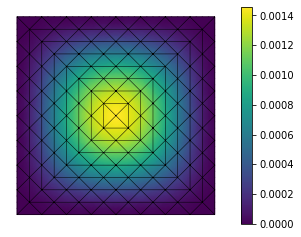

In [2]:
%%time
m = MeshTri.init_symmetric()
# m = MeshTri.init_refdom()
m.refine(3)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    # ep = 1
    return ddot(dd(u), dd(v))


K = asm(bilinf, ib)
f = asm(unit_load, ib)

dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], 
                    dofs['right'].facet['u_n'], 
                    dofs['top'].facet['u_n'], 
                    dofs['buttom'].facet['u_n']
                   ))


x = solve(*condense(K, f, D=D)) # condense 连接

ax = draw(m)

plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)

### Testing solvers

In [3]:
m = MeshTri.init_symmetric()
# m = MeshTri.init_refdom()
m.refine(5)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    # ep = 1
    return ddot(dd(u), dd(v))


K = asm(bilinf, ib)
f = asm(unit_load, ib)

dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], 
                    dofs['right'].facet['u_n'], 
                    dofs['top'].facet['u_n'], 
                    dofs['buttom'].facet['u_n']
                   ))

- Default

In [4]:
%%time
x = solve(*condense(K, f, D=D))
x

Wall time: 226 ms


array([ 0.        ,  0.        ,  0.        , ..., -0.00278389,
        0.00278389,  0.00392698])

- Krylov

In [5]:
%%time
x = solve(*condense(K, f, D=D), solver=solver_iter_krylov())
x

Wall time: 42.9 ms


array([ 0.        ,  0.        ,  0.        , ..., -0.00278389,
        0.00278389,  0.00392698])

- PCG

In [6]:
%%time
x = solve(*condense(K, f, D=D), solver=solver_iter_pcg())
x

Wall time: 50.9 ms


array([ 0.        ,  0.        ,  0.        , ..., -0.00278389,
        0.00278389,  0.00392698])

### Features

In [7]:
dofs

{'left': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x000002571B1C1A88>, nodal_ix=array([  0,   3,   6,  14,  22,  42,  50,  61,  62, 146, 154, 165, 166,
        205, 206, 243, 244, 546, 554, 565, 566, 605, 606, 643, 644, 757,
        758, 795, 796, 853, 854, 857, 858], dtype=int64), facet_ix=array([   1,    9,   20,   21,   60,   61,   98,   99,  212,  213,  250,
         251,  308,  309,  312,  313,  804,  805,  842,  843,  900,  901,
         904,  905, 1124, 1125, 1128, 1129, 1332, 1333, 1336, 1337],
       dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=[0], edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None)),
 'right': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x000002571B1C1A88>, nodal_ix=array([  1,   2,   8,  17,  19,  45,  47,  71,  72, 149, 151, 175, 176,
        219, 220, 229, 230, 549, 551, 575, 576, 619, 620, 629, 630, 771,
        772, 781, 782, 909, 910, 913, 914], dtype=int64), facet_ix

In [8]:
dofs['left'].facet['u_n']

array([2114, 2122, 2133, 2134, 2173, 2174, 2211, 2212, 2325, 2326, 2363,
       2364, 2421, 2422, 2425, 2426, 2917, 2918, 2955, 2956, 3013, 3014,
       3017, 3018, 3237, 3238, 3241, 3242, 3445, 3446, 3449, 3450],
      dtype=int64)

In [9]:
ib.nodal_dofs # nodes

array([[   0,    1,    2, ..., 2110, 2111, 2112]], dtype=int64)

In [10]:
ib.facet_dofs # midpoint

array([[2113, 2114, 2115, ..., 8318, 8319, 8320]], dtype=int64)

In [11]:
x

array([ 0.        ,  0.        ,  0.        , ..., -0.00278389,
        0.00278389,  0.00392698])

In [12]:
m.p # position of nodes

array([[0.      , 1.      , 1.      , ..., 0.5     , 0.515625, 0.484375],
       [0.      , 0.      , 1.      , ..., 0.84375 , 0.828125, 0.828125]])

In [13]:
m.t # element

array([[   0,    1,    2, ..., 2107, 2110, 2104],
       [ 545,  549,  552, ..., 2108, 2111, 2105],
       [ 547,  550,  553, ..., 2109, 2112, 2106]], dtype=int64)

In [14]:
m.facets_satisfying(lambda x: x[0] == 0)

array([   1,    9,   20,   21,   60,   61,   98,   99,  212,  213,  250,
        251,  308,  309,  312,  313,  804,  805,  842,  843,  900,  901,
        904,  905, 1124, 1125, 1128, 1129, 1332, 1333, 1336, 1337],
      dtype=int64)

In [15]:
m.boundary_nodes()

array([  0,   1,   2,   3,   5,   6,   8,  10,  13,  14,  16,  17,  19,
        20,  22,  23,  41,  42,  44,  45,  47,  48,  50,  51,  57,  58,
        61,  62,  71,  72,  81,  82, 145, 146, 148, 149, 151, 152, 154,
       155, 161, 162, 165, 166, 175, 176, 185, 186, 201, 202, 205, 206,
       215, 216, 219, 220, 229, 230, 233, 234, 243, 244, 247, 248, 545,
       546, 548, 549, 551, 552, 554, 555, 561, 562, 565, 566, 575, 576,
       585, 586, 601, 602, 605, 606, 615, 616, 619, 620, 629, 630, 633,
       634, 643, 644, 647, 648, 753, 754, 757, 758, 767, 768, 771, 772,
       781, 782, 785, 786, 795, 796, 799, 800, 833, 834, 837, 838, 853,
       854, 857, 858, 909, 910, 913, 914, 965, 966, 969, 970], dtype=int64)

In [16]:
ib.get_dofs()

DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x000002571B1C1A88>, nodal_ix=array([  0,   1,   2,   3,   5,   6,   8,  10,  13,  14,  16,  17,  19,
        20,  22,  23,  41,  42,  44,  45,  47,  48,  50,  51,  57,  58,
        61,  62,  71,  72,  81,  82, 145, 146, 148, 149, 151, 152, 154,
       155, 161, 162, 165, 166, 175, 176, 185, 186, 201, 202, 205, 206,
       215, 216, 219, 220, 229, 230, 233, 234, 243, 244, 247, 248, 545,
       546, 548, 549, 551, 552, 554, 555, 561, 562, 565, 566, 575, 576,
       585, 586, 601, 602, 605, 606, 615, 616, 619, 620, 629, 630, 633,
       634, 643, 644, 647, 648, 753, 754, 757, 758, 767, 768, 771, 772,
       781, 782, 785, 786, 795, 796, 799, 800, 833, 834, 837, 838, 853,
       854, 857, 858, 909, 910, 913, 914, 965, 966, 969, 970], dtype=int64), facet_ix=array([   0,    1,    3,    4,    6,    7,    9,   10,   16,   17,   20,
         21,   30,   31,   40,   41,   56,   57,   60,   61,   70,   71,
         74,   75,   84,   85,   88,   89

In [17]:
m.interior_nodes()

array([   4,    7,    9, ..., 2110, 2111, 2112])

In [18]:
m.facets # edges of the midpoints

array([[   0,    0,    0, ..., 2110, 2110, 2111],
       [ 545,  546,  547, ..., 2111, 2112, 2112]], dtype=int64)

In [19]:
x[m.facets_satisfying(lambda x: x[0] == 1)]

array([1.27736131e-03, 0.00000000e+00, 2.54819849e-04, 2.54819849e-04,
       8.41673223e-05, 2.22498414e-04, 8.41673223e-05, 2.22498414e-04,
       5.82697504e-05, 1.21343878e-04, 1.73107946e-05, 2.54228961e-05,
       2.02866181e-05, 3.39570556e-06, 8.15854171e-06, 2.02866181e-05,
       1.23441379e-03, 1.20498784e-03, 1.17228294e-03, 1.23441379e-03,
       4.74815909e-04, 3.42046585e-04, 7.21842768e-04, 7.15719109e-04,
       1.50766078e-04, 1.13351056e-03, 1.17063475e-03, 1.10404465e-03,
       9.15844187e-04, 9.20538710e-04, 9.72126876e-04, 9.81991629e-04])

### Testing $f$
Problem:
$$ \Delta^2 u = f \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
note:
$$\Delta^{2} \equiv \nabla^{4}=\frac{\partial^{4}}{\partial x^{4}}+2 \frac{\partial^{4}}{\partial x^{2} \partial y^{2}}+\frac{\partial^{4}}{\partial y^{4}}$$
in this case, we consider set $\Omega=(0,1) \times(0,1)$ and try
$$ 
f(x, y)=24\left[\left(x^{2}-x+1\right)^{2}+\left(y^{2}-y+1\right)^{2}+12\left(x^{2}-x\right)\left(y^{2}-y\right)\right]-40
$$
from 
$$
u(x, y)=x^{2}(1-x)^{2} y^{2}(1-y)^{2}
$$

Wall time: 140 ms


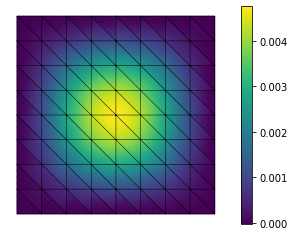

In [155]:
%%time
m = MeshTri() 
# m = MeshTri.init_symmetric() 
m.refine(3)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    # print('w', w.x, '\n')
    # print('a', a)
    # print(24*((x**2-x+1)**2+(y**2-y+1)**2+12*(x-1)*(y-1)*x*y)-40-(24*(x**2*(x-1)**2+y**2*(y-1)**2)+2*((12*x**2-12*x+2)*(12*y**2-12*y+2))))
    return (24*((x**2-x+1)**2+(y**2-y+1)**2+12*(x-1)*(y-1)*x*y)-40)*v
    # return (24*(x**2*(x-1)**2+y**2*(y-1)**2)+2*((12*x**2-12*x+2)*(12*y**2-12*y+2)))*v

dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], 
                    dofs['right'].facet['u_n'], 
                    dofs['top'].facet['u_n'],
                    dofs['buttom'].facet['u_n']
                   ))

K = asm(bilinf, ib)
f = asm(mybih, ib)

u = solve(*condense(K, f, D=D), solver=solver_iter_pcg()) 

ax = draw(m)
plot(ib, u, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)
# plot(ib, u, shading='gouraud', colorbar=True, Nrefs=2)

#### Compute original

In [156]:
def orig(x, y):
    return (x * y * (1 - x) * (1 - y))**2

# fig = plt.figure()
ax = Axes3D(fig)
x = ib.doflocs[0]
y = ib.doflocs[1]
u_ori = orig(x, y)

In [157]:
bias = u-u_ori

print('inf-norm: ', max(u-u_ori))

inf-norm:  0.009201176378959668


In [159]:
print('L^2-Norm/nodes: ', np.linalg.norm(bias, ord=2)/len(bias))

L^2-Norm/nodes:  0.00027685894381405246


#### Plotting norm

In [147]:
norm_list = []
maxorder = 9
def orig(x, y):
    return (x * y * (1 - x) * (1 - y))**2

for order in range(1, maxorder):
    m = MeshTri()
    # m = MeshTri.init_symmetric()
    m.refine(order)

    e = ElementTriMorley()
    ib = InteriorBasis(m, e)


    @BilinearForm
    def bilinf(u, v, w):
        return ddot(dd(u), dd(v))


    @LinearForm
    def mybih(v, w):
        x, y = w.x
        return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                      (y - 1) * x * y) - 40) * v


    dofs = ib.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

    K = asm(bilinf, ib)
    f = asm(mybih, ib)

    u = solve(*condense(K, f, D=D), solver=solver_iter_pcg())
    
    ax = Axes3D(fig)
    x = ib.doflocs[0]
    y = ib.doflocs[1]
    u_ori = orig(x, y)

    bias = u - u_ori
    meanl2norm = np.linalg.norm(bias, ord=2) / len(bias)
    print('2^-'+str(order)+' case')
    # print('inf-norm: ', max(u - u_ori))
    print(' Mean L^2-Norm: ', meanl2norm)
    norm_list.append(meanl2norm)

2^-1 case
 Mean L^2-Norm:  0.0008158118139807287
2^-2 case
 Mean L^2-Norm:  0.0005049547565439847
2^-3 case
 Mean L^2-Norm:  0.00027685894381405246
2^-4 case
 Mean L^2-Norm:  0.0001460035901343649
2^-5 case
 Mean L^2-Norm:  7.512704333900427e-05
2^-6 case
 Mean L^2-Norm:  3.812970507283017e-05
2^-7 case
 Mean L^2-Norm:  1.9211147865018284e-05
2^-8 case
 Mean L^2-Norm:  9.642762095642101e-06


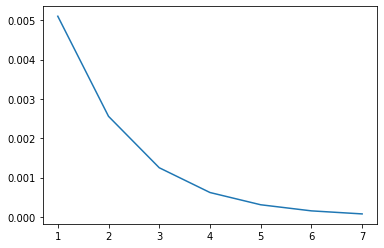

In [154]:
plt.plot(range(1,maxorder), norm_list)
plt.show()

 - $\delta h \cdot norm$

In [180]:
norm_list = []
maxorder = 7
def orig(x, y):
    return (x * y * (1 - x) * (1 - y))**2

for order in range(1, maxorder):
    m = MeshTri()
    # m = MeshTri.init_symmetric()
    m.refine(order)

    e = ElementTriMorley()
    ib = InteriorBasis(m, e)


    @BilinearForm
    def bilinf(u, v, w):
        return ddot(dd(u), dd(v))


    @LinearForm
    def mybih(v, w):
        x, y = w.x
        return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                      (y - 1) * x * y) - 40) * v


    dofs = ib.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

    K = asm(bilinf, ib)
    f = asm(mybih, ib)

    u = solve(*condense(K, f, D=D), solver=solver_iter_pcg())
    
    ax = Axes3D(fig)
    x = ib.doflocs[0]
    y = ib.doflocs[1]
    u_ori = orig(x, y)

    bias = u - u_ori
    delta_h = (1/(2**order))**2
    l2norm = (np.linalg.norm(bias, ord=2) * delta_h)**0.5
    print('2^-'+str(order)+' case')
    print('inf-norm: ', max(u - u_ori))
    print(' L^2-Norm: ', l2norm)
    norm_list.append(l2norm)

2^-1 case
inf-norm:  0.009028877858592034
 L^2-Norm:  0.07140604902513199
2^-2 case
inf-norm:  0.009149450517349556
 L^2-Norm:  0.05056019635052778
2^-3 case
inf-norm:  0.009201176378959668
 L^2-Norm:  0.03535804248201999
2^-4 case
inf-norm:  0.010314736071447684
 L^2-Norm:  0.02492158872534039
2^-5 case
inf-norm:  0.010414381990966648
 L^2-Norm:  0.01760603362562543
2^-6 case
inf-norm:  0.010441817165397901
 L^2-Norm:  0.012446334234159074


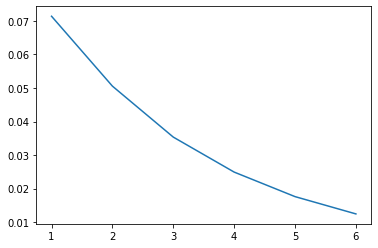

In [177]:
plt.plot(range(1,maxorder), norm_list)

#### Plotting bias

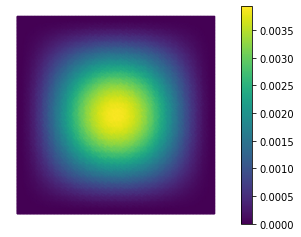

In [169]:
plot(ib, u_ori, shading='gouraud', colorbar=True, Nrefs=2)

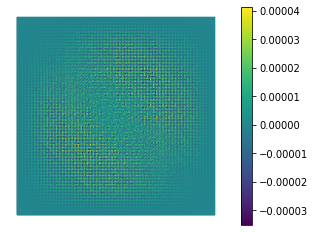

In [153]:
plot(ib, u-u_ori, shading='gouraud', colorbar=True)

## PoissonP1
two ways to set $0$ boundary conditions

$$ -\Delta u=1 \ in \  \Omega$$
$$ u = 0 \ on \ \Gamma$$

### Solving with `I` ( to keep )

#### a circle

In [7]:
%%time
m = MeshTri.init_circle()
m.refine(5)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = 4 * asm(unit_load, basis)

x1 = solve(*condense(K, f, I=m.interior_nodes()), solver=solver_iter_pcg())

# ax = draw(m)
# plot(basis, x1, ax=ax, shading='gouraud', colorbar=True)

max(x1)

Wall time: 24.8 s


0.9934392813425619

2.2447734455798556

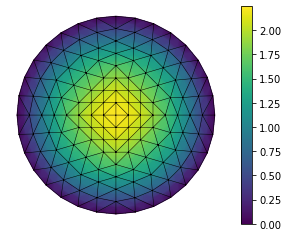

In [8]:
m = MeshTri.init_circle()

e = ElementTriMorley()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = 4 * asm(unit_load, basis)

x1 = solve(*condense(K, f, I=m.interior_nodes()), solver=solver_iter_pcg())
ax = draw(m)
plot(basis, x1, ax=ax, shading='gouraud', colorbar=True)

max(x1)

#### a square

Wall time: 144 ms


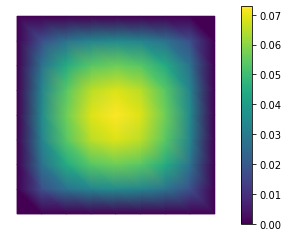

In [9]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x1 = solve(*condense(K, f, I=m.interior_nodes()))

plot(m, x1, shading='gouraud', colorbar=True)

`D=basis.get_dofs()`

Wall time: 38.9 ms


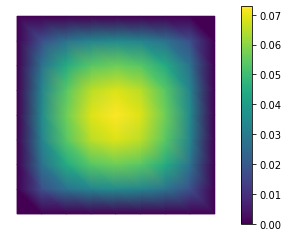

In [134]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x1 = solve(*condense(K, f, D=basis.get_dofs()))

plot(m, x1, shading='gouraud', colorbar=True)

In [135]:
basis.get_dofs()

DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225C0AACF88>, nodal_ix=array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18, 25,
       26, 27, 29, 30, 32, 33, 34, 35, 36, 39, 40, 49, 50, 53, 54],
      dtype=int64), facet_ix=array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 14, 15, 24, 25, 28, 29, 32,
       33, 36, 37, 40, 41, 50, 51, 54, 55, 64, 65, 68, 69, 72, 73],
      dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None))

### Solving with `D` ( to abandon )

`D=m.boundary_nodes()`

Wall time: 30.9 ms


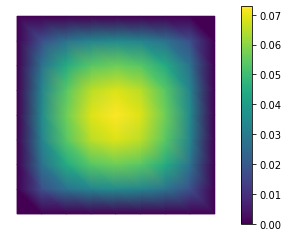

In [52]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x2 = solve(*condense(A, b, D=m.boundary_nodes()), solver=solver_iter_pcg())

plot(m, x2, shading='gouraud', colorbar=True)

Detailed `D`

In [72]:
%%time

m = MeshTri()
m.refine(9)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

dofs = basis.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u']
                   ))

x2 = solve(*condense(A, b, D=D), solver=solver_iter_pcg()) # like vstack
# ax = draw(m)
# plot(basis, x2, ax=ax, shading='gouraud', colorbar=True)

Wall time: 8.64 s


In [73]:
max(x2)*2

0.14734225193953787

In [46]:
D

array([  0,   2,   5,  10,  14,  26,  30,  39,  40,  82,  86,  95,  96,
       117, 118, 135, 136, 290, 294, 303, 304, 325, 326, 343, 344, 405,
       406, 423, 424, 465, 466, 469, 470,   1,   3,   7,  13,  17,  29,
        33,  49,  50,  85,  89, 105, 106, 131, 132, 149, 150, 293, 297,
       313, 314, 339, 340, 357, 358, 419, 420, 437, 438, 521, 522, 525,
       526,   2,   3,   8,  16,  18,  32,  34,  53,  54,  88,  90, 109,
       110, 145, 146, 153, 154, 296, 298, 317, 318, 353, 354, 361, 362,
       433, 434, 441, 442, 541, 542, 545, 546,   0,   1,   4,   9,  11,
        25,  27,  35,  36,  81,  83,  91,  92, 113, 114, 121, 122, 289,
       291, 299, 300, 321, 322, 329, 330, 401, 402, 409, 410, 445, 446,
       449, 450], dtype=int64)

In [47]:
Dm = m.boundary_nodes()

In [48]:
for i in Dm:
    if i in D:
        pass
    else:
        print('False')

which means that you can simply use `m.boundary_nodes()`

### Try Morley

In [151]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriMorley()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x_morley = solve(*condense(K, f, D=m.boundary_nodes()), solver=solver_iter_pcg()) # like vstack

# ax = draw(m)
# plot(basis, x_morley, ax=ax, colorbar=True)

max(x_morley)

Wall time: 22.2 ms


0.15031814667944876

In [152]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x_morley = solve(*condense(K, f, D=m.boundary_nodes()), solver=solver_iter_pcg()) # like vstack

# ax = draw(m)
# plot(basis, x_morley, ax=ax, colorbar=True)

max(x_morley)

Wall time: 6.98 ms


0.07278262867647059

In [90]:
help(unit_load)

Help on LinearForm in module skfem.assembly.form.linear_form object:

class LinearForm(skfem.assembly.form.form.Form)
 |  LinearForm(form: Callable = None, dtype: type = <class 'numpy.float64'>)
 |  
 |  A linear form for finite element assembly.
 |  
 |  Used similarly as :class:`~skfem.assembly.BilinearForm` with the expection
 |  that forms take two parameters `v` and `w`.
 |  
 |  Method resolution order:
 |      LinearForm
 |      skfem.assembly.form.form.Form
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  assemble(self, u: skfem.assembly.basis.basis.Basis, v: Union[skfem.assembly.basis.basis.Basis, NoneType] = None, **kwargs) -> numpy.ndarray
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from skfem.assembly.form.form.Form:
 |  
 |  __call__(self, *args)
 |      Call self as a function.
 |  
 |  __init__(self, form: Callable = None, dtype: type = <class 'numpy.float64'>)
 |      Initialize self.  See help(typ

In [70]:
x_morley

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0703125 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04296875, 0.        , 0.        ,
       0.04296875, 0.        , 0.        , 0.        , 0.04296875,
       0.0546875 , 0.0546875 , 0.0546875 , 0.0546875 , 0.04296875])

### Try P2

`D=m.boundary_nodes()`

Wall time: 133 ms


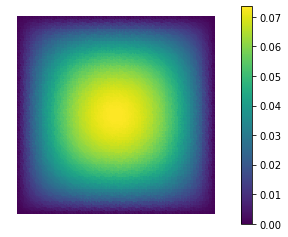

In [38]:
%%time

m = MeshTri()
m.refine(5)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, D=m.boundary_nodes()))

plot(basis, x, colorbar=True)

`I=m.interior_nodes()`

In [39]:
# m.interior_nodes()

Wall time: 164 ms


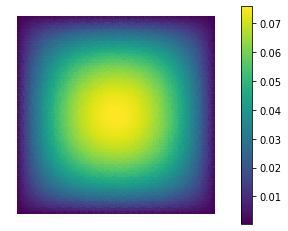

In [40]:
%%time

m = MeshTri()
m.refine(5)

e = ElementTriP2()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x1 = solve(*condense(A, b, D=m.boundary_nodes()))

plot(basis, x1, colorbar=True)

In [42]:
plot(basis, x-x1, colorbar=True)

ValueError: operands could not be broadcast together with shapes (1089,) (4225,) 

`detailed D`

Wall time: 60.8 ms


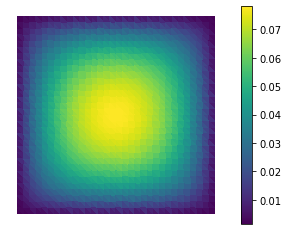

In [165]:
%%time

m = MeshTri()
m.refine(4)

e = ElementTriP2()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

dofs = basis.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u']
                   ))


x = solve(*condense(A, b, D=D))

plot(basis, x, colorbar=True)

In [121]:
dofs

{'left': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225C081CC88>, nodal_ix=array([0, 2], dtype=int64), facet_ix=array([1], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=[0], edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None)),
 'right': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225C081CC88>, nodal_ix=array([1, 3], dtype=int64), facet_ix=array([3], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=[0], edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None)),
 'top': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225C081CC88>, nodal_ix=array([2, 3], dtype=int64), facet_ix=array([4], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=[0], edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None)),
 'buttom': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0

In [123]:
dofs['left'].nodal['u']

array([0, 2], dtype=int64)

In [114]:
D

array([0, 2, 1, 3, 2, 3, 0, 1], dtype=int64)

In [115]:
x

array([0.    , 0.    , 0.    , 0.    , 0.1875, 0.1875, 0.25  , 0.1875,
       0.1875])

### Try P0

`D=m.boundary_nodes()`

In [2]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(2)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, D=m.boundary_nodes()))

# plot(basis, x)

Wall time: 4.99 ms


In [3]:
x

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0703125 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04296875, 0.        , 0.        ,
       0.04296875, 0.        , 0.        , 0.        , 0.04296875,
       0.0546875 , 0.0546875 , 0.0546875 , 0.0546875 , 0.04296875])

`D=basis.find_dofs()`

In [4]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(2)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, D=basis.find_dofs()))

# plot(basis, x)

Wall time: 3.96 ms


In [8]:
m.boundary_nodes()

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18],
      dtype=int64)

In [10]:
basis.find_dofs()

{'all': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x000001DD18713048>, nodal_ix=array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18],
       dtype=int64), facet_ix=array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 14, 15, 24, 25, 28, 29],
       dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None))}

In [5]:
x

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0703125 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04296875, 0.        , 0.        ,
       0.04296875, 0.        , 0.        , 0.        , 0.04296875,
       0.0546875 , 0.0546875 , 0.0546875 , 0.0546875 , 0.04296875])

### Comparing the results

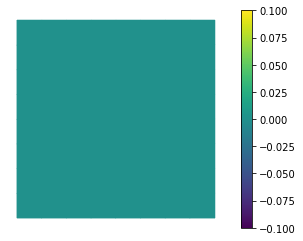

In [14]:
plot(m, x1-x2, shading='gouraud', colorbar=True)

### Changing $f$

In [165]:
%%time

m = MeshTri()
m.refine(8)

e = ElementTriP1()
basis = InteriorBasis(m, e)


@LinearForm
def myf(v, w):
    x, y = w.x
    # print('w', w.x, '\n')
    # print('a', a)
    return 2 * (x * (1 - x) + y * (1 - y)) * v


K = asm(laplace, basis)
f = asm(myf, basis)

x = solve(*condense(K, f, D=m.boundary_nodes()),
          solver=solver_iter_pcg())  # like vstack

# ax = draw(m)
# plot(basis, x, ax=ax, colorbar=True)

max(x)

Wall time: 1.02 s


0.06249924831370889

In [170]:
print('expected', 1/16, 'got', max(x))

expected 0.0625 got 0.06249924831370889


## Mesh Structure
a mess

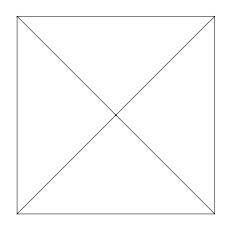

In [50]:
m = MeshTri.init_symmetric()
m.refine(0)

draw(m)

### Boundary nodes

In [51]:
m.boundary_nodes()+1

array([1, 2, 3, 4], dtype=int64)

### Interior nodes

In [53]:
m.interior_nodes()+1

array([5])

### Coordinates

In [54]:
m.p

array([[0. , 1. , 1. , 0. , 0.5],
       [0. , 0. , 1. , 1. , 0.5]])

### Facets

In [57]:
m.facets

array([[0, 0, 0, 1, 1, 2, 2, 3],
       [1, 3, 4, 2, 4, 3, 4, 4]], dtype=int64)

In [52]:
m.boundary_facets()

array([0, 1, 3, 5], dtype=int64)

In [59]:
m.interior_facets()

array([2, 4, 6, 7], dtype=int64)

### Basis

In [91]:
m = MeshTri.init_symmetric()
m.refine(0)

In [92]:
e = ElementTriP0()
basis = InteriorBasis(m, e) # only interior points

In [93]:
basis.interior_dofs

array([[0, 1, 2, 3]], dtype=int64)

In [94]:
basis.doflocs

array([[0.75, 0.75, 0.25, 0.25],
       [0.25, 0.75, 0.75, 0.75]])

In [95]:
basis.edge_dofs

array([], shape=(0, 0), dtype=int64)

In [96]:
basis.get_dofs()

DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BD0E6148>, nodal_ix=array([0, 1, 2, 3], dtype=int64), facet_ix=array([0, 1, 3, 5], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=slice(0, 0, None), facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=[0])

In [169]:
basis.find_dofs() # no constrictions added, return all

{'all': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225C3A87B08>, nodal_ix=array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  13,  14,
         16,  17,  18,  25,  26,  27,  29,  30,  32,  33,  34,  35,  36,
         39,  40,  49,  50,  53,  54,  81,  82,  83,  85,  86,  88,  89,
         90,  91,  92,  95,  96, 105, 106, 109, 110, 113, 114, 117, 118,
        121, 122, 131, 132, 135, 136, 145, 146, 149, 150, 153, 154],
       dtype=int64), facet_ix=array([  0,   1,   2,   4,   5,   7,   8,   9,  10,  11,  14,  15,  24,
         25,  28,  29,  32,  33,  36,  37,  40,  41,  50,  51,  54,  55,
         64,  65,  68,  69,  72,  73, 112, 113, 116, 117, 120, 121, 130,
        131, 134, 135, 144, 145, 148, 149, 152, 153, 156, 157, 160, 161,
        176, 177, 180, 181, 232, 233, 236, 237, 252, 253, 256, 257],
       dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=[0], edge_rows=slice(0, 0, None), interior_rows

In [99]:
basis.find_dofs()['all']

DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BD0E6148>, nodal_ix=array([0, 1, 2, 3], dtype=int64), facet_ix=array([0, 1, 3, 5], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=slice(0, 0, None), facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=[0])

In [102]:
basis.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

{'left': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BD0E6148>, nodal_ix=array([0, 3], dtype=int64), facet_ix=array([1], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=slice(0, 0, None), facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=[0]),
 'right': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BD0E6148>, nodal_ix=array([1, 2], dtype=int64), facet_ix=array([3], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=slice(0, 0, None), facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=[0]),
 'top': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BD0E6148>, nodal_ix=array([2, 3], dtype=int64), facet_ix=array([5], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=slice(0, 0, None), facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=[0]),
 'buttom': DofsView

## Boundary conditions
`condense()` 
> using `*` to unzip the parameters in `solve(*condense())`

- use $D$ to represent indices to dismiss
- use $I$ to represent indices to keep

> the eliminated dofs will be set to zero by dafault and can be determined by setting $x$

> usage of $I$ not clear so far 

In [19]:
condense(A, b, D=m.boundary_nodes())

(<77x77 sparse matrix of type '<class 'numpy.float64'>'
 	with 349 stored elements in Compressed Sparse Row format>,
 array([0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125, 0.0078125,
        0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125, 0.015625 ,
        0.0078125, 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.0078125, 0.0078125, 0.0078125,
        0.015625 , 0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125,
        0.0078125, 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.0078125,
        0.0078125, 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.0078125, 0.0078125, 0.015625 ,
        0.015625 , 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.0156

## two ways to assemble basis

In [170]:
from skfem import *
from skfem.models.poisson import laplace, unit_load
m = MeshTri()
m.refine(0)
basis = InteriorBasis(m, ElementTriP1())
A = laplace.assemble(basis)

In [172]:
m.boundary_nodes()

array([0, 1, 2, 3], dtype=int64)

In [173]:
m.boundary_facets()

array([0, 1, 3, 4], dtype=int64)

In [23]:
basis.find_dofs()

{'all': DofsView(obj=<skfem.assembly.dofs.Dofs object at 0x00000225BDEABD88>, nodal_ix=array([0, 1, 2, 3], dtype=int64), facet_ix=array([0, 1, 3, 4], dtype=int64), edge_ix=array([], dtype=int64), interior_ix=array([], dtype=int64), nodal_rows=[0], facet_rows=slice(0, 0, None), edge_rows=slice(0, 0, None), interior_rows=slice(0, 0, None))}

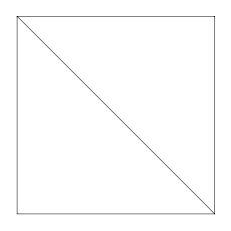

In [24]:
draw(m)

In [21]:
b = unit_load.assemble(basis)

In [22]:
b

array([0.01041667, 0.02083333, 0.02083333, 0.01041667, 0.03125   ,
       0.03125   , 0.0625    , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.0625    , 0.03125   , 0.03125   ,
       0.0625    , 0.03125   , 0.03125   , 0.03125   , 0.0625    ,
       0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ])

In [23]:
b = asm(unit_load, basis)

In [24]:
b

array([0.01041667, 0.02083333, 0.02083333, 0.01041667, 0.03125   ,
       0.03125   , 0.0625    , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.0625    , 0.03125   , 0.03125   ,
       0.0625    , 0.03125   , 0.03125   , 0.03125   , 0.0625    ,
       0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ])

## Supported elements

In [25]:
import skfem.element
dir(skfem.element)

['DiscreteField',
 'Element',
 'ElementComposite',
 'ElementH1',
 'ElementHcurl',
 'ElementHdiv',
 'ElementHex1',
 'ElementHex2',
 'ElementHexS2',
 'ElementLineHermite',
 'ElementLineMini',
 'ElementLineP1',
 'ElementLineP2',
 'ElementLinePp',
 'ElementQuad0',
 'ElementQuad1',
 'ElementQuad2',
 'ElementQuadBFS',
 'ElementQuadDG',
 'ElementQuadP',
 'ElementQuadS2',
 'ElementTetMini',
 'ElementTetN0',
 'ElementTetP0',
 'ElementTetP1',
 'ElementTetP2',
 'ElementTetRT0',
 'ElementTriArgyris',
 'ElementTriDG',
 'ElementTriMini',
 'ElementTriMorley',
 'ElementTriP0',
 'ElementTriP1',
 'ElementTriP2',
 'ElementTriRT0',
 'ElementVectorH1',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'discrete_field',
 'element',
 'element_composite',
 'element_global',
 'element_h1',
 'element_hcurl',
 'element_hdiv',
 'element_hex',
 'element_line',
 'element_quad',
 'element_tet',
 'element_tri',
 'element_vector_

In [ ]:
# ### adding facet

# m = MeshTri.init_symmetric()
# m.refine(2)

# e = ElementTriMorley()
# ib = InteriorBasis(m, e)


# @BilinearForm
# def bilinf(u, v, w):
#     from skfem.helpers import dd, ddot, trace, eye
#     d = 0.1
#     E = 200e9
#     nu = 0.3

#     def C(T):
#         return E / (1 + nu) * (T + nu / (1 - nu) * eye(trace(T), 2))

#     return d**3 / 12.0 * ddot(C(dd(u)), dd(v))


# K = asm(bilinf, ib)
# f = 1e6 * asm(unit_load, ib)


# dofs = ib.find_dofs({
#     'left':  m.facets_satisfying(lambda x: x[0] == 0),
#     'right': m.facets_satisfying(lambda x: x[0] == 1),
#     'top':   m.facets_satisfying(lambda x: x[1] == 1),
#     'buttom': m.facets_satisfying(lambda x: x[1] == 0)
# })

# D = np.concatenate((
#     dofs['left'].nodal['u'],
#     dofs['left'].facet['u_n'],
#     dofs['right'].facet['u_n'],
#     dofs['top'].facet['u_n'],
#     dofs['right'].nodal['u'],
#     dofs['top'].nodal['u'],
#     dofs['buttom'].nodal['u']
# ))

# x = solve(*condense(K, f, D=D))

# ax = draw(m)
# plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)

In [277]:
# %%time
# m = MeshTri.init_symmetric()  # square
# # m = MeshTri.init_refdom() # triangle
# m.refine(2)

# e = ElementTriMorley()
# ib = InteriorBasis(m, e)


# @BilinearForm
# def bilinf(u, v, w):
#     # ep = 1
#     return ddot(dd(u), dd(v))


# K = asm(bilinf, ib)
# f = asm(unit_load, ib)

# x = solve(*condense(K, f, I=m.interior_nodes()))

# ax = draw(m)
# plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)

- original pic

In [99]:
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
# from matplotlib import pyplot as plt


# def orig(x, y):
#     return (x * y * (1 - x) * (1 - y))**2


# fig = plt.figure()
# ax = Axes3D(fig)
# x1 = np.arange(0, 1, 0.01)
# x2 = np.arange(0, 1, 0.01)
# x1, x2 = np.meshgrid(x1, x2)
# y = orig(x1, x2)
# plt.xlabel('x1')
# plt.ylabel('x2')
# ax.plot_surface(x1, x2, y, rstride=1, cstride=1, cmap='rainbow')
# plt.show()